# Лабораторная работа №8
**Решение краевых задач**

Чуворкин Михаил А-13а-19 Вариант 47

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import itertools

### Задача 8.1. 
Найти аналитическое и приближенное решения краевой задачи
$$
\begin{cases}
-u'' + pu' + qu = f(x), \quad x \in \left(a,b \right) \\
u(a) = ua, \quad u(b) = ub
\end{cases}
$$
с заданным шагом $h$ . Решение системы разностных уравнений найти c помощью метода прогонки.

Вариант 47:
$$
\begin{cases}
-u'' - 0.5 u' + 3 u = 10x^2 - 3x - 9 \quad x \in \left(0, 1 \right) \\
u(0) = 0 \quad u(1) = -5.44
\end{cases}
$$

1. Найти аналитическое решение задачи
2. Cоставить разностную схему и выписать коэффициенты матрицы системы уравнений и коэффициенты правой части.
3. Найти решение задачи по разностной схеме с точностью $0.001$.
4. Построить на одном чертеже графики приближенного и аналитического решений, и график погрешности.

$$ -\lambda^2 - 0.5 \lambda + 3 = 0 $$

$$ \lambda_1 = -2 \\ \lambda_2 = \frac{3}{2} $$

$$ u_{\text{оо}} = C_1 e^{-2x} + C_2 e^{\frac{3}{2}x} $$

$$ u_{\text{чн}} = A x^2 + Bx + C $$

$$ -2A - 0.5(2Ax + B) + 3(Ax^2 + Bx + C) = 10x^2 - 3x - 9 $$

$$
\begin{cases}
A = \frac{10}{3} \\
B = \frac{1}{9} \\
C = -\frac{41}{54}
\end{cases}
$$

$$ u = C_1 e^{-2x} + C_2 e^{\frac{3}{2} x} + \frac{10}{3} x^2 + \frac{1}{9} x - \frac{41}{54} $$

$$
\begin{cases}
u(0) = C_1 + C_2 - \frac{41}{54} = 0 \\
u(1) = C_1 e^{-2} + C_2 e^{\frac{3}{2}} + \frac{145}{54} = -5.44
\end{cases}
$$


$$
\begin{cases}
C_1 = \frac{41}{54} - \frac{-\frac{10969}{1350} - \frac{41}{54}e^{-2}}{e^{\frac{3}{2}} - e^{-2}} \\ \\
C_2 = \frac{-\frac{10969}{1350} - \frac{41}{54}e^{-2}}{e^{\frac{3}{2}} - e^{-2}}
\end{cases}
$$

Создадим разностную схему:
$$
-\frac{u_{i-1}-2u_i + u_{i+1}}{h^2} - 0.5 \frac{u_{i+1}-u_{i-1}}{2h} + 3u_i = 10x_i^2 - 3 x_i - 9
$$
$$
u_{i-1}\left(0.25h - 1\right) + u_{i}\left(2 + 3 h^2\right) + u_{i+1}\left(-1-0.25h\right) = \left(10x_i^2 - 3 x_i - 9 \right)h^2
$$

In [2]:
# точное решение
def U_exact(x):
    c2 = ( (-10969 / 1350) - (41/54) * np.exp(-2) ) / (np.exp(1.5) - np.exp(-2))
    c1 = (41/54) - c2
    return c1 * np.exp(-2 * x) + c2 * np.exp(1.5 * x) + (10/3) * x**2 + (1/9) * x - (41/54)

def f(x):
    return 10 * x**2 - 3 * x - 9

# метод прогонки
def tridiagonal(a, b):
    assert a.shape[0] == a.shape[1] == b.shape[0]
    n = b.shape[0]
    x = np.zeros(n)
    
    alpha = np.zeros(n)
    beta = np.zeros(n)
    gamma = np.zeros(n)
    
    # прямой ход
    gamma[0] = a[0, 0] #b_0
    alpha[0] = - (a[0, 1] / gamma[0]) # -(c_0 / gamma_0)
    beta[0]  =   b[0] / gamma[0] # d_0 / gamma_0
    
    for i in range(1, n - 1):
        gamma[i] = a[i, i] + a[i, i-1] * alpha[i-1] # b_i + a_i * alpha_{i-1}
        alpha[i] = - (a[i, i+1] / gamma[i]) # -(c_i / gamma_i)
        beta[i] = ( b[i] - a[i, i-1] * beta[i-1] ) / gamma[i] # (d_i - a_i * beta_{i-1}) / gamma_i
    
    gamma[-1] = a[-1, -1] + a[-1, -2] * alpha[-2]
    beta[-1] = (b[-1] - a[-1, -2] * beta[-2]) / gamma[-1]
    
    # обратный ход
    x[-1] = beta[-1]
    for i in range(n-1, 0, -1):
        x[i-1] = alpha[i-1] * x[i] + beta[i-1]
        
    return x

# создание трехдиагональной матрицы
def create_u_matrix(a, b, h):
    steps = int((b - a) / h)
    #print(f'Steps: {steps}')
    u = np.zeros((steps, steps))
    u[0, 0] = 1
    for i in range(1, u.shape[0]-1):
        u[i, i-1:i+2] = [0.25*h-1, 2+3*h**2, -1-0.25*h]
    u[-1, -1] = 1
    return u

# создание вектора правой части
def create_fh2(a, b, ua, ub, h):
    steps = int((b - a) / h)
    fh = h**2 * f(np.linspace(a, b, steps))
    fh[0] = ua
    fh[-1] = ub
    return fh

# решение с использованием шага
def solution_h(a, b, ua, ub, h):
    u = create_u_matrix(a, b, h)
    fh = create_fh2(a, b, ua, ub, h)
    res = tridiagonal(u, fh)
    return res

# решение с использованием погрешности: (оценка по Рунге)
def solution_eps(a, b, ua, ub, eps):
    h = 0.1
    u_res = solution_h(a, b, ua, ub, h)
    h /= 2
    u_res2 = solution_h(a, b, ua, ub, h)
    while np.max(np.abs(u_res2[::2] - u_res)) > eps:
        h /= 2
        u_res = u_res2
        u_res2 = solution_h(a, b, ua, ub, h)
    return u_res2, h

In [3]:
a, b = 0, 1
ua, ub = 0, -5.44
eps = 0.001

u, h = solution_eps(a, b, ua, ub, eps)
x_data = np.linspace(a, b, u.shape[0])

In [4]:
print(f'Значение шага: h = {h}')
print(f'Количество узлов: N = {u.shape[0]}')
err = np.abs(U_exact(x_data) - u)
print(f'Максимальное значение погрешности: {np.max(err)}')

Значение шага: h = 9.765625e-05
Количество узлов: N = 10240
Максимальное значение погрешности: 3.2084398936316205e-05


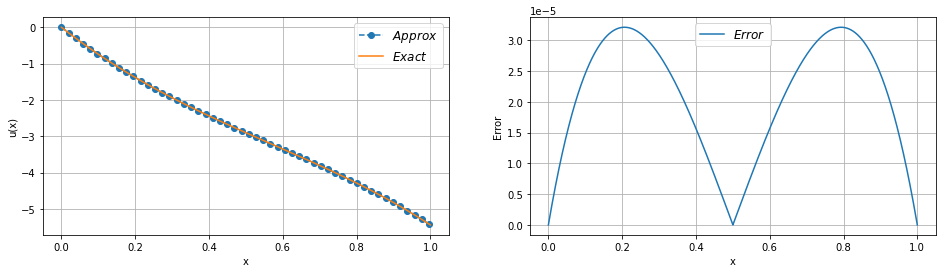

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (16, 4))
axs[0].plot(x_data[::200], u[::200], 'o--',label='$Approx$')
axs[0].plot(x_data, U_exact(x_data), label='$Exact$')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u(x)')
axs[0].grid()
axs[0].legend(loc='best',fontsize=12)
axs[1].plot(x_data, err, label='$Error$')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Error')
axs[1].grid()
axs[1].legend(loc='best', fontsize=12)
plt.show()

Заметим, что визуально графики точного и приближенного решения совпадают, а также погрешность полученного решения не превышает заданную

### Задача 8.2.
Стержень составляется из трех частей одинаковой длины 1 и с разными коэффициентами теплопроводности. Концы стержня поддерживаются при постоянной температуре. В каком порядке следует составить части стержня, чтобы указанная точка x0 стержня имела максимальную температуру?

Математически задача формулируется следующим образом: найти приближенное решение краевой задачи
$$
\begin{cases}
-(k(x)u')' + q(x)u = f(x) \quad x \in \left(a, b \right) \\
u(a) = Ua, \quad u(b) = Ub
\end{cases}
$$
$$
\text{где } k(x) = 
\begin{cases}
k1(x), \quad 0 \leq x \leq 1 \\
k2(x), \quad 1 < x \leq 2 \\
k3(x), \quad 2 < x \leq 3 \\
\end{cases}
$$
при каждой конфигурации стержня.
Сравнить полученные значения температуры в фиксированной точке в каждом варианте. Выбрать оптимальный результат.

Вариант 47:
$$
x_0 = 1.5
$$
$$
k(x) = 
\begin{cases}
1 + x, \quad 0 \leq x \leq 1 \\
\frac{2}{0.5 x + 2}, \quad 1 < x \leq 2 \\
24, \quad 2 < x \leq 3
\end{cases}
$$
$$
\begin{cases}
u(0) = 2 \\
u(3) = 9
\end{cases}
$$
$$
-(k(x)u')' + 3u = 10 x^2 - 3x - 9 \quad x \in \left(a, b \right) \\
$$

1. Составить подпрограмму, вычисляющую функцию $k(x)$ из индивидуального варианта.
2. Для каждого варианта конфигурации стержня произвести расчет по разностной схеме с шагом $h = \frac{b − a}{100}$
3. Построить на одном чертеже графики приближенного решения для каждой конфигурации стержня.
4. Сравнив полученные решения, выбрать оптимальный результат.
5. Оформить отчет по задаче.

$$
-k_{i-1/2}u_{i-1} + (k_{i-1/2} + k_{i+1/2}+3h^2)u_{i} - k_{i+1/2}u_{i+1} = h^2(10 x^2 - 3x - 9), \quad i=1,...N-1
$$
$$
u_0 = 2, \quad u_N = 9
$$

In [6]:
funcs = (lambda x: 1+x, lambda x:2/(0.5*x+2), lambda x:24)
def k(x):
    global k1, k2, k3
    if 0 <= x <= 1: return k1(x)
    elif 1 < x <= 2: return k2(x)
    elif 2 < x <= 3: return k3(x)
    

# создание трехдиагональной матрицы
def create_u_matrix(a, b, h):
    steps = int((b - a) / h)
    x = np.linspace(a, b, steps)
    u = np.zeros((steps, steps))
    u[0, 0] = 1
    for i in range(1, u.shape[0]-1):
        kim05 = k((x[i] + x[i-1]) / 2 )
        kip05 = k((x[i+1] + x[i]) / 2 )
        u[i, i-1:i+2] = [-kim05, kim05+kip05+3*h**2, -kip05]
    u[-1, -1] = 1
    return u

# создание вектора правой части
def create_fh2(a, b, ua, ub, h):
    steps = int((b - a) / h)
    fh = h**2 * f(np.linspace(a, b, steps))
    fh[0] = ua
    fh[-1] = ub
    return fh

# определение ближайшей точки сетки
def get_nearest_xy(arrX, arrY, x):
    if not arrX.any() == x:
        idx = (np.abs(arrX - x)).argmin()
        return arrX[idx], arrY[idx]
    else:
        idx = np.where(arrX == x)[0][0]
        return arrX[idx], arrY[idx]

In [7]:
x0 = 1.5
a, b = 0, 3
ua, ub = 2, 9
h = (b - a) / 100

In [8]:
fs = itertools.permutations(funcs, 3)
flist = []
for t in fs:
    flist.append(t)
kfunc = np.vectorize(k, otypes=['float'])

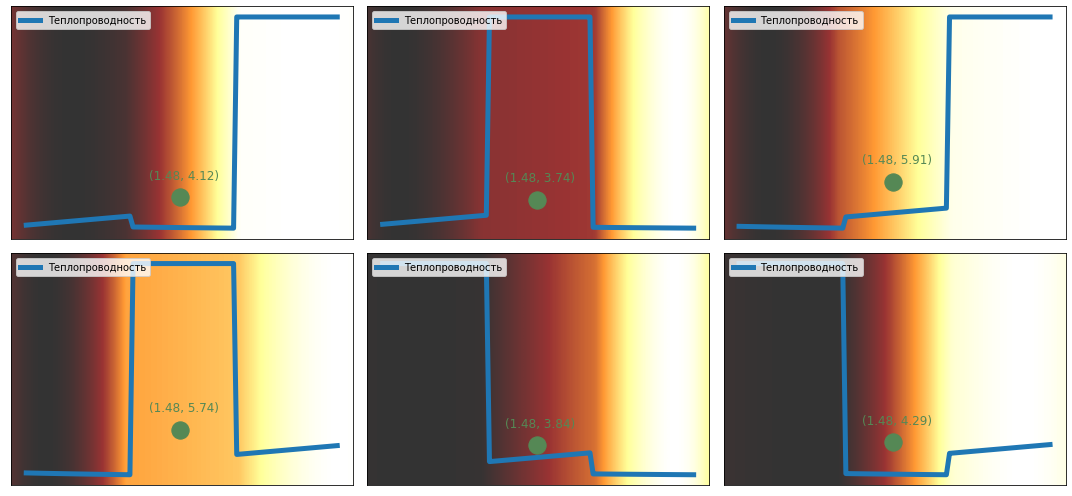

In [9]:
heatlist = []
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, _ in enumerate(axs.flat):
    k1, k2, k3 = flist[i]
    u = create_u_matrix(a, b, h)
    fh = create_fh2(a, b, ua, ub, h)
    res = tridiagonal(u, fh)
    x_data = np.linspace(a, b, u.shape[0])
    
    xdot, ydot = get_nearest_xy(x_data, res, x0)
    heatlist.append(ydot)
    ux, uy = np.meshgrid(x_data, res)
    kx, ky = np.meshgrid(x_data, kfunc(x_data))
    
    #axs.flat[i].axvline(x=1, linewidth=7.0, c='#00aa00', alpha=0.4)
    #axs.flat[i].axvline(x=2, linewidth=7.0, c='#00aa00', alpha=0.4)
    axs.flat[i].plot(x_data, kfunc(x_data), label='Теплопроводность', linewidth=5.0) #, c='#000000'
    #axs.flat[i].plot(x_data, res, label='t(x)', linewidth=7.0) #, c='#000000' 
    axs.flat[i].scatter(xdot, ydot, s=300, c='#558855')
    axs.flat[i].annotate(f'({round(xdot, 2)}, {round(ydot, 2)})', (xdot - 0.3, ydot+2), c='#558855', fontsize=12)
    axs.flat[i].legend(loc='upper left')
    plotlim = axs.flat[i].get_xlim() + axs.flat[i].get_ylim()  
    axs.flat[i].imshow(uy.T, interpolation='bicubic', extent=plotlim, cmap='afmhot', alpha=0.8, aspect='auto')
    #axs.flat[i].imshow(ky.T, interpolation='bicubic', extent=plotlim, cmap='afmhot', alpha=0.4, aspect='auto')
    
plt.tight_layout()
plt.show()

На графиках выше цветом фона изображена температура, синей линией - значение коэффициента теплопроводности, зеленая точка - указанная точка $x_0$

Максимальное значение температуры среди всех конфигураций: 5.9146


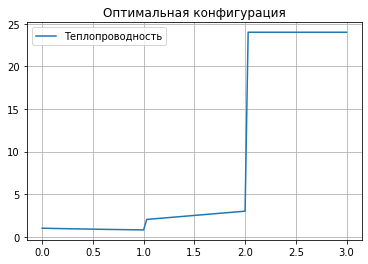

In [10]:
maxheat = max(heatlist)
print(f'Максимальное значение температуры среди всех конфигураций: {round(maxheat, 4)}')
configidx = heatlist.index(maxheat)
k1, k2, k3 = flist[configidx]
plt.plot(x_data, kfunc(x_data), label='Теплопроводность')
plt.grid()
plt.legend()
plt.title('Оптимальная конфигурация')
plt.show()